In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans

def load_data():
    customers_df = pd.read_csv("Customers.csv")
    products_df = pd.read_csv("Products.csv")
    transactions_df = pd.read_csv("Transactions.csv")
    return customers_df, products_df, transactions_df

In [11]:
# Step 1: Load the data
customers_df, products_df, transactions_df = load_data()

Customer Data Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   CustomerID    200 non-null    object
 1   CustomerName  200 non-null    object
 2   Region        200 non-null    object
 3   SignupDate    200 non-null    object
dtypes: object(4)
memory usage: 6.4+ KB
None
       CustomerID      CustomerName         Region  SignupDate
count         200               200            200         200
unique        200               200              4         179
top         C0001  Lawrence Carroll  South America  2024-11-11
freq            1                 1             59           3


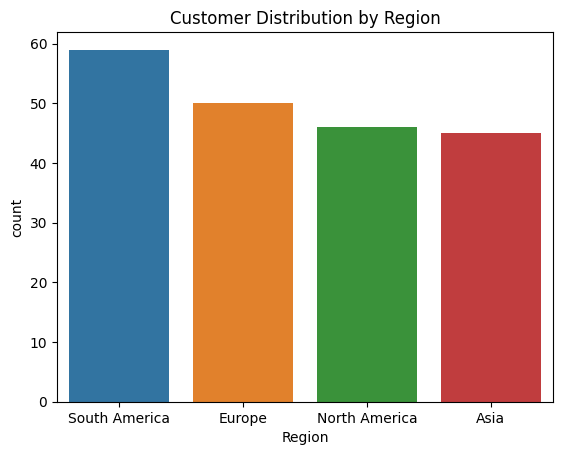

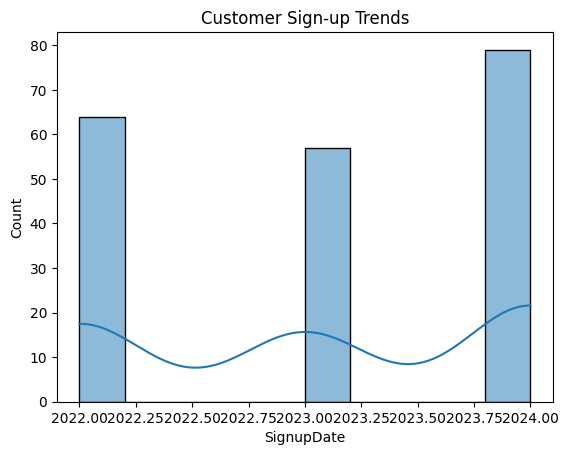

In [17]:
# Step 2: EDA on Customers Data
print("Customer Data Overview:")
print(customers_df.info())
print(customers_df.describe(include='all'))

sns.countplot(x=customers_df["Region"], order=customers_df["Region"].value_counts().index)
plt.title("Customer Distribution by Region")
plt.show()

# Convert the 'SignupDate' column to datetime format
customers_df['SignupDate'] = pd.to_datetime(customers_df['SignupDate'], errors='coerce')

# Now you can proceed with the histogram
sns.histplot(customers_df["SignupDate"].dt.year, bins=10, kde=True)
plt.title("Customer Sign-up Trends")
plt.show()

# Conclusions
# 1. Customers are majorly from specific regions.
# 2. The highest number of signups occurred in recent years.

Product Data Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ProductID    100 non-null    object 
 1   ProductName  100 non-null    object 
 2   Category     100 non-null    object 
 3   Price        100 non-null    float64
dtypes: float64(1), object(3)
memory usage: 3.2+ KB
None
       ProductID            ProductName Category       Price
count        100                    100      100  100.000000
unique       100                     66        4         NaN
top         P001  ActiveWear Smartwatch    Books         NaN
freq           1                      4       26         NaN
mean         NaN                    NaN      NaN  267.551700
std          NaN                    NaN      NaN  143.219383
min          NaN                    NaN      NaN   16.080000
25%          NaN                    NaN      NaN  147.767500
50%          NaN

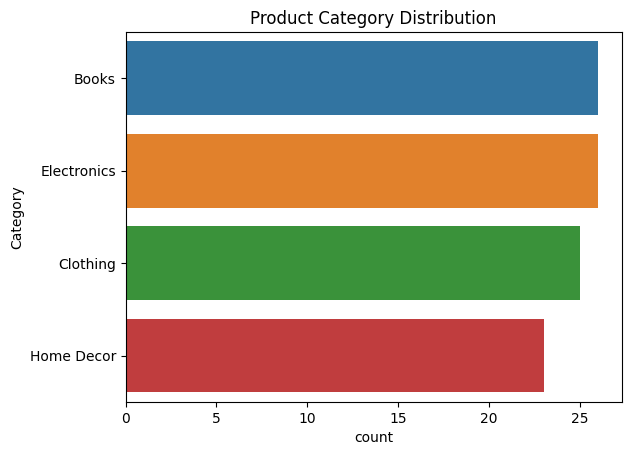

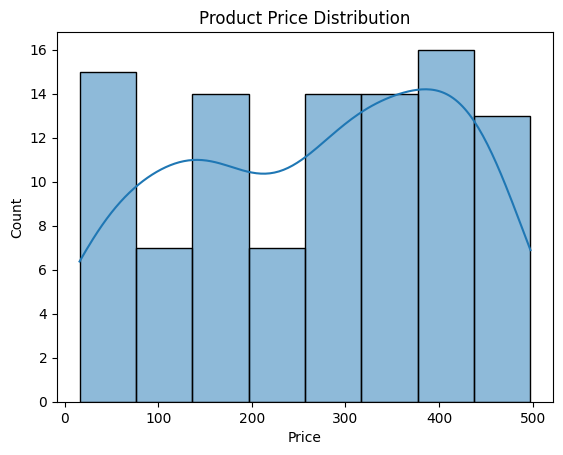

In [18]:
# Step 3: EDA on Products Data
print("Product Data Overview:")
print(products_df.info())
print(products_df.describe(include='all'))

sns.countplot(y=products_df["Category"], order=products_df["Category"].value_counts().index)
plt.title("Product Category Distribution")
plt.show()

sns.histplot(products_df["Price"], kde=True)
plt.title("Product Price Distribution")
plt.show()

# Conclusions
# 1. Certain categories dominate the product offerings.
# 2. Prices are concentrated within a specific range.

Transaction Data Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   TransactionID    1000 non-null   object 
 1   CustomerID       1000 non-null   object 
 2   ProductID        1000 non-null   object 
 3   TransactionDate  1000 non-null   object 
 4   Quantity         1000 non-null   int64  
 5   TotalValue       1000 non-null   float64
 6   Price            1000 non-null   float64
dtypes: float64(2), int64(1), object(4)
memory usage: 54.8+ KB
None
          Quantity   TotalValue       Price
count  1000.000000  1000.000000  1000.00000
mean      2.537000   689.995560   272.55407
std       1.117981   493.144478   140.73639
min       1.000000    16.080000    16.08000
25%       2.000000   295.295000   147.95000
50%       3.000000   588.880000   299.93000
75%       4.000000  1011.660000   404.40000
max       4.000000  1991.040000   

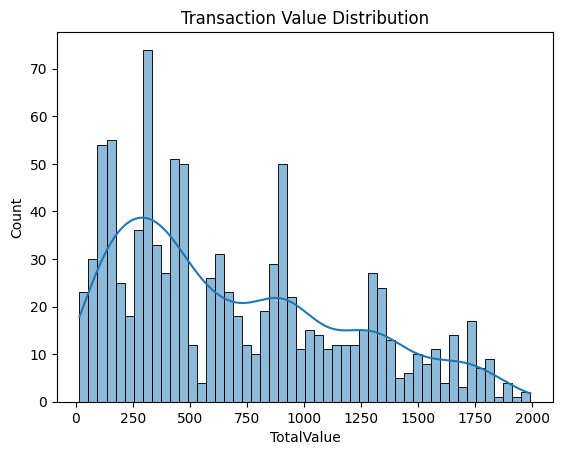

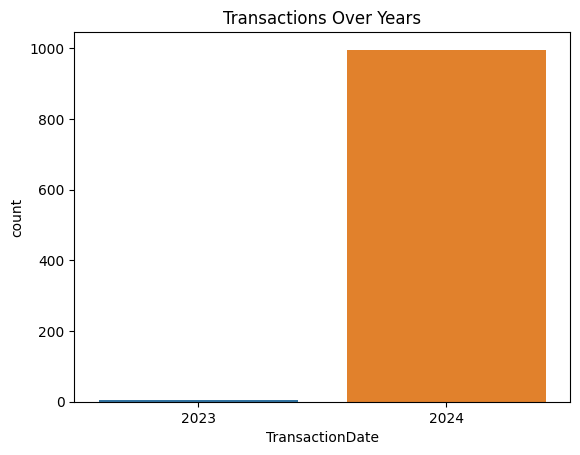

In [20]:
# Step 4: EDA on Transactions Data
print("Transaction Data Overview:")
print(transactions_df.info())
print(transactions_df.describe())

sns.histplot(transactions_df["TotalValue"], bins=50, kde=True)
plt.title("Transaction Value Distribution")
plt.show()

# Convert the 'TransactionDate' column to datetime format
transactions_df['TransactionDate'] = pd.to_datetime(transactions_df['TransactionDate'], errors='coerce')

# Now you can proceed with the countplot
sns.countplot(x=transactions_df["TransactionDate"].dt.year)
plt.title("Transactions Over Years")
plt.show()

# Conclusions
# 1. Majority of transactions are of smaller values.
# 2. Transaction volume has grown in recent years.

In [21]:
# Step 5: Lookalike Model

def build_lookalike_model(customers_df, transactions_df):
    data = transactions_df.merge(customers_df, on='CustomerID', how='left')
    data_grouped = data.groupby('CustomerID').agg({'TotalValue': 'sum', 'Quantity': 'sum'}).reset_index()
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data_grouped[['TotalValue', 'Quantity']])
    similarity_matrix = cosine_similarity(data_scaled)
    similarity_df = pd.DataFrame(similarity_matrix, index=data_grouped.CustomerID, columns=data_grouped.CustomerID)
    lookalike_dict = {}
    for cust in customers_df.CustomerID[:20]:
        similar_customers = similarity_df[cust].sort_values(ascending=False)[1:4].to_dict()
        lookalike_dict[cust] = similar_customers
    lookalike_df = pd.DataFrame.from_dict(lookalike_dict, orient='index')
    lookalike_df.to_csv("Lookalike.csv")

build_lookalike_model(customers_df, transactions_df)


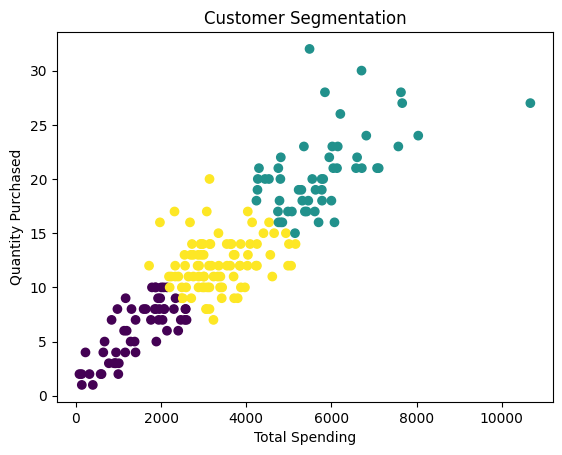

In [22]:

# Step 6: Customer Segmentation

def customer_segmentation(customers_df, transactions_df):
    customer_data = transactions_df.groupby('CustomerID').agg({'TotalValue': 'sum', 'Quantity': 'sum'}).reset_index()
    scaler = StandardScaler()
    customer_scaled = scaler.fit_transform(customer_data[['TotalValue', 'Quantity']])
    kmeans = KMeans(n_clusters=3, random_state=42)
    customer_data['Cluster'] = kmeans.fit_predict(customer_scaled)
    plt.scatter(customer_data['TotalValue'], customer_data['Quantity'], c=customer_data['Cluster'], cmap='viridis')
    plt.xlabel('Total Spending')
    plt.ylabel('Quantity Purchased')
    plt.title('Customer Segmentation')
    plt.show()

customer_segmentation(customers_df, transactions_df)